# Skenario 14 LSTM : Weekly Dataset - Many Feature With One Label

In [1]:
import pandas as pd
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib import pyplot as plt

import numpy as np
import random as rn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

import sys, time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.models import load_model

In [2]:
# Setting seed to ensure reproducibility.
rn.seed(14)
np.random.seed(14)
tf.random.set_seed(14)

# visual formating the graph
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.style.use(['seaborn-whitegrid'])
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
plt.rcParams['font.family'] = 'cambria'

In [3]:
# date-time parsing function for loading the dataset
def parser(X):
    return pd.to_datetime(X, format = '%Y-%m-%d')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(sequence, n_steps):
    data_observation = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_data = i + n_steps
        # check if the data beyond the sequence
        if end_data > len(sequence):
            break
        # gather input and output parts of the pattern
        data_seq = sequence[i:end_data]
        data_observation.append(data_seq)
    return np.array(data_observation)

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_LSTM(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1] )
    
    # weight and biases initialization
    init = RandomUniform(minval=0, maxval=1)
    
    # Define Model
    model = Sequential()
    model.add(LSTM(units=neurons,
                  use_bias=True,
                  activation='tanh',
                  recurrent_activation='sigmoid',
                  batch_input_shape=(batch_size, X.shape[1], X.shape[2]),
                  kernel_initializer=init,
                  bias_initializer=init,
                  recurrent_initializer=init))
    model.add(Dense(units=1,activation='tanh',
                    use_bias=True,
                    kernel_initializer=init,
                    bias_initializer=init))
    model.compile(loss='mean_squared_error', 
                  optimizer='adam', 
                  clipvalue=0.5)
    
    # configure early stopping
    es = EarlyStopping(monitor='val_loss',  
                       mode='auto',
                       min_delta=0,
                       verbose=1, 
                       patience=2)
    
    # summarize the model
    print(model.summary())
    plot_model(model, 'model-WM1.png', show_shapes=True)
    
    # start counting training time
    start = time.time()
    
    # Fit the model
    history = model.fit(X, y,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        verbose=0, validation_data=(X, y),
                        callbacks=[es], shuffle=False)
    # finished calculating training time
    end = time.time()
    print("Time Took :{:3.2f} min".format( (end-start)/60 ))
    
        # plot learning curves
    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.plot(history.history['loss'], label='train',color='#073763ff')
    plt.plot(history.history['val_loss'], label='val',color='tab:red')
    plt.legend()
    plt.show()
    
    # save model and architecture to single file
    model.save('model-WM1.h5')
    
    return model
    

# make a one-step forecast
def forecast_LSTM(model, batch_size, X):
    X = X.reshape(1,1,X.shape[0])
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

# visualize the dataset
def plot_series(series):
    plt.plot(series,color ='#073763ff')
    plt.ylabel('Number Of Tourist',fontsize=15)
    plt.xlabel('Time',fontsize=15)
    plt.title("Weekly Visitors to TNGMb in 2013 - 2018",fontsize=20)
    plt.show()
    
# visualize the dataset after make dataset stationary    
def plot_stationary(diff_values):
    plt.plot(diff_values,color='#073763ff')
    plt.gca().set(title = "Transform data to be stationary with Differencing" , 
                  xlabel='Week + i', 
                  ylabel='#Tourist',)
    plt.show()
    plt.hist(diff_values,color='#073763ff')
    plt.gca().set(title = "Histogram Of Stationary  Data With Differencing" , 
                  xlabel='Value Ditribution', 
                  ylabel='Frequenzy')
    plt.show()
    diff_values.describe()

In [4]:
series=read_csv('02-02 TNGMb-Weekly.csv', 
                header=0,
                parse_dates=[0], 
                index_col=0,
                squeeze=True,
                date_parser=parser)

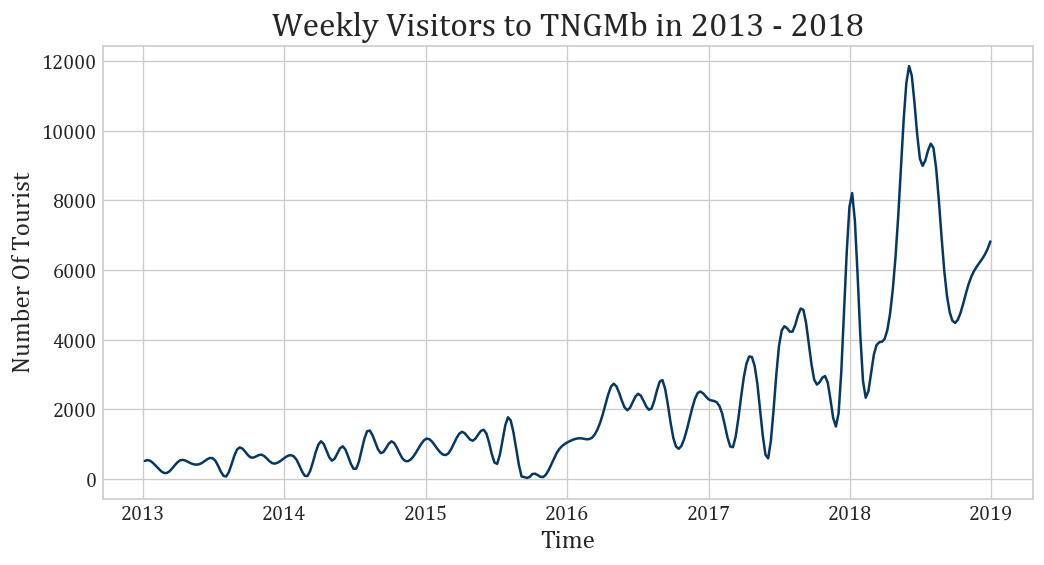

In [5]:
plot_series(series)

In [6]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

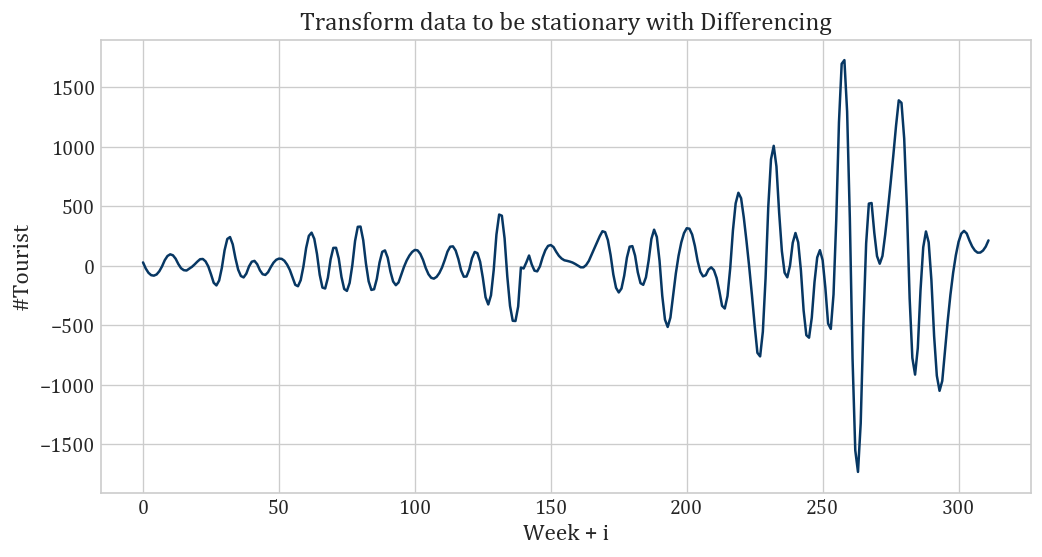

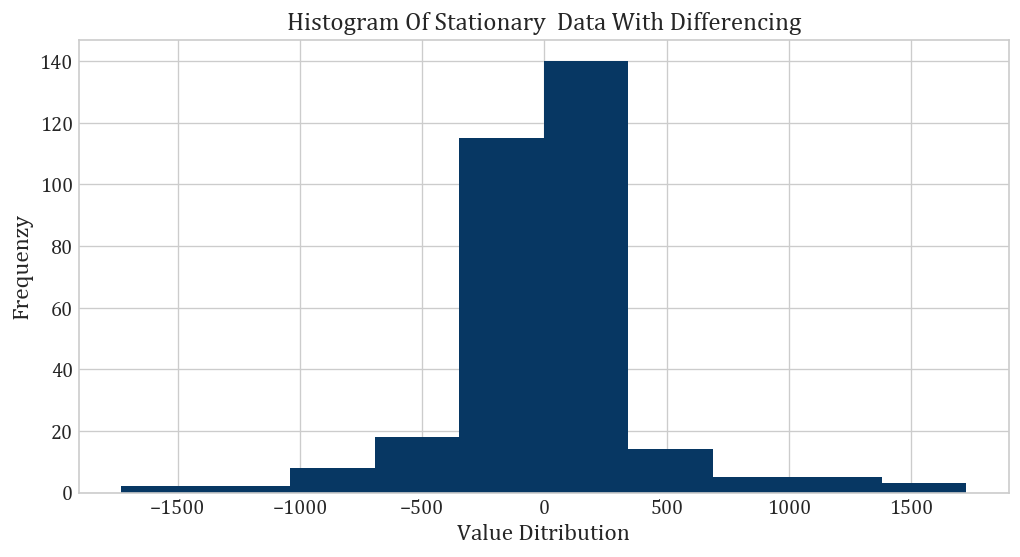

In [7]:
plot_stationary(diff_values)

In [8]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 5)
print('Time series data point dimensions : %d Observation, %d Feature' % supervised.shape)
print('---------------------------------------------------------------------------')
pd.DataFrame(supervised).head(5)

Time series data point dimensions : 308 Observation, 5 Feature
---------------------------------------------------------------------------


,0,1,2,3,4
0,27,-24,-60,-80,-84
1,-24,-60,-80,-84,-74
2,-60,-80,-84,-74,-47
3,-80,-84,-74,-47,-6
4,-84,-74,-47,-6,46


In [9]:
# split data into train and test
train, test = supervised[0:-52],supervised[-52:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [10]:
print('Train sample data point dimensions : %d Observation, %d Feature ' % train_scaled.shape)
print('---------------------------------------------------------------------------')
pd.DataFrame(train_scaled).tail(5)

Train sample data point dimensions : 256 Observation, 5 Feature 
---------------------------------------------------------------------------


,0,1,2,3,4
251,-0.349548,-0.719084,-0.811966,-0.581994,-0.082797
252,-0.687783,-0.764885,-0.576720,-0.082797,0.579582
253,-0.738688,-0.470738,-0.071225,0.579582,0.975080
254,-0.411765,0.161323,0.599512,0.975080,1.000000
255,0.290724,1.000000,1.000000,1.000000,0.652733


In [11]:
print('Test sample data point dimensions : %d Observation, %d Feature' % test_scaled.shape)
print('---------------------------------------------------------------------------')
pd.DataFrame(test_scaled).tail(5)

Test sample data point dimensions : 52 Observation, 5 Feature
---------------------------------------------------------------------------


,0,1,2,3,4
47,0.167421,-0.009669,-0.248677,-0.285370,-0.299839
48,0.100679,-0.060560,-0.276353,-0.299839,-0.299035
49,0.044118,-0.095165,-0.291005,-0.299035,-0.285370
50,0.005656,-0.113486,-0.290191,-0.285370,-0.258842
51,-0.014706,-0.112468,-0.276353,-0.258842,-0.217042


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 4)                    144       
_________________________________________________________________
dense (Dense)                (1, 1)                    5         
Total params: 149
Trainable params: 149
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00337: early stopping
Time Took :17.67 min


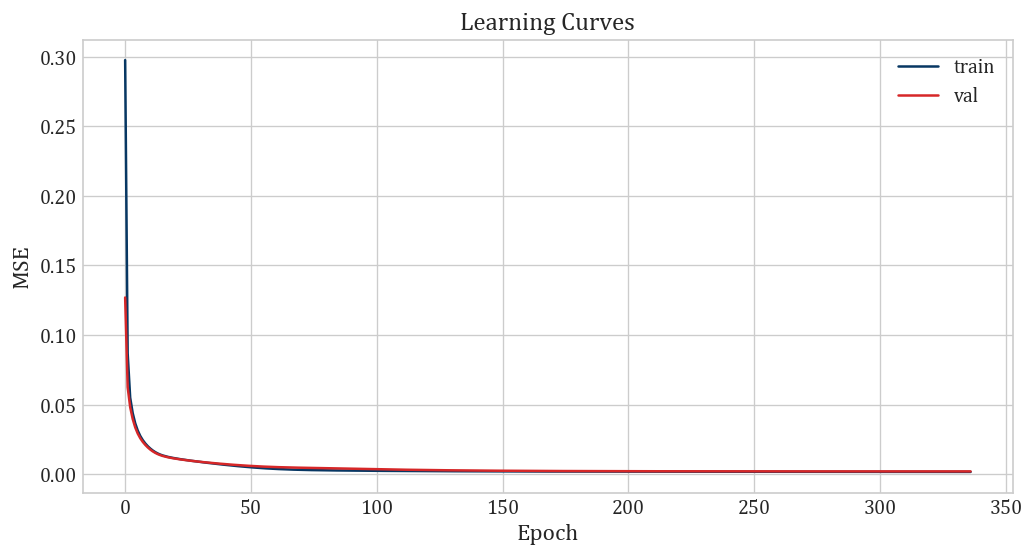

In [12]:
# fit the base mode
LSTM_model = fit_LSTM(train_scaled, 1, 3000, 4)

In [13]:
LSTM_model = load_model('model-WM1.h5')

Week=1, Predicted=286, Expected=548
Week=2, Predicted=122, Expected=524
Week=3, Predicted=18, Expected=464
Week=4, Predicted=46, Expected=384
Week=5, Predicted=236, Expected=300
Week=6, Predicted=534, Expected=226
Week=7, Predicted=814, Expected=179
Week=8, Predicted=1026, Expected=173
Week=9, Predicted=1102, Expected=219
Week=10, Predicted=988, Expected=300
Week=11, Predicted=757, Expected=395
Week=12, Predicted=554, Expected=482
Week=13, Predicted=464, Expected=540
Week=14, Predicted=524, Expected=553
Week=15, Predicted=698, Expected=531
Week=16, Predicted=856, Expected=493
Week=17, Predicted=933, Expected=452
Week=18, Predicted=859, Expected=426
Week=19, Predicted=675, Expected=416
Week=20, Predicted=444, Expected=427
Week=21, Predicted=261, Expected=461
Week=22, Predicted=215, Expected=515
Week=23, Predicted=351, Expected=571
Week=24, Predicted=622, Expected=607
Week=25, Predicted=991, Expected=601
Week=26, Predicted=1308, Expected=529
Week=27, Predicted=1470, Expected=385
Week=28,

Week=215, Predicted=4449, Expected=1192
Week=216, Predicted=4505, Expected=937
Week=217, Predicted=4493, Expected=916
Week=218, Predicted=4654, Expected=1212
Week=219, Predicted=4944, Expected=1735
Week=220, Predicted=5455, Expected=2347
Week=221, Predicted=6159, Expected=2913
Week=222, Predicted=7121, Expected=3316
Week=223, Predicted=8374, Expected=3519
Week=224, Predicted=9692, Expected=3505
Week=225, Predicted=10854, Expected=3255
Week=226, Predicted=11684, Expected=2752
Week=227, Predicted=11948, Expected=2020
Week=228, Predicted=11714, Expected=1258
Week=229, Predicted=10956, Expected=703
Week=230, Predicted=10020, Expected=596
Week=231, Predicted=9435, Expected=1090
Week=232, Predicted=9208, Expected=1983
Week=233, Predicted=9313, Expected=2989
Week=234, Predicted=9497, Expected=3822
Week=235, Predicted=9469, Expected=4265
Week=236, Predicted=9096, Expected=4387
Week=237, Predicted=8375, Expected=4328
Week=238, Predicted=7160, Expected=4230
Week=239, Predicted=5938, Expected=423

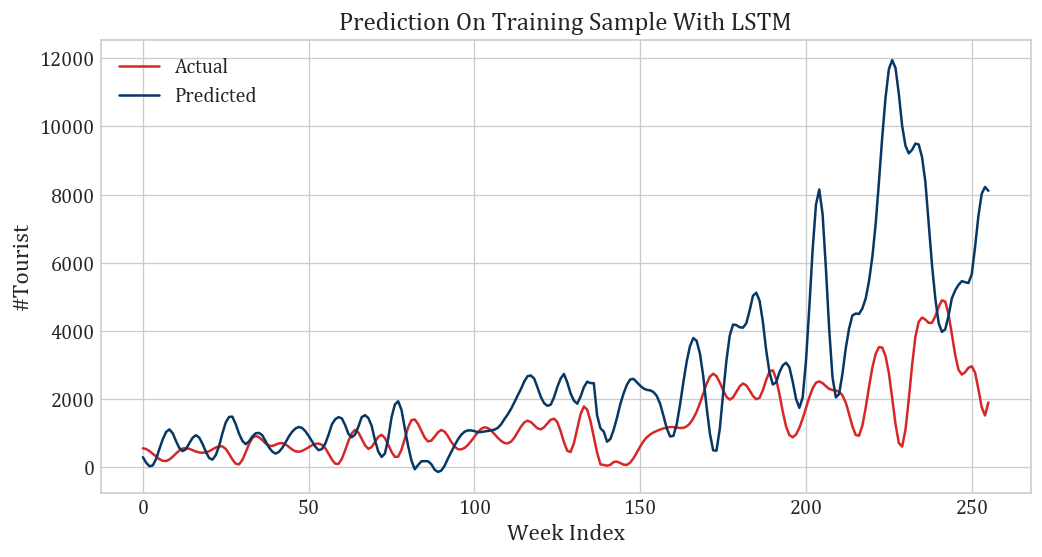

In [14]:
# walk-forward validation on the training data
predictions_train = list()
for i in range(len(train_scaled)):
    # make one-step forecast
    X, y = train_scaled[i, 0:-1], train_scaled[i, -1]
    yhat = forecast_LSTM(LSTM_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(train_scaled)-i)
    # store forecast
    predictions_train.append(yhat)
    expected_train = raw_values[i+1]
    print('Week=%d, Predicted=%.0f, Expected=%.0f' % (i+1, yhat, expected_train))

# report performance
rmse_train = sqrt(mean_squared_error(raw_values[1:len(train_scaled)+1], predictions_train))
print('---------------------------------------------------------------------------')
print('Train RMSE: %.1f' % rmse_train)
print('---------------------------------------------------------------------------')
# line plot of observed vs predicted
plt.plot(raw_values[1:len(train_scaled)+1], label = 'Actual',color='tab:red')
plt.plot(predictions_train, label = 'Predicted',color='#073763ff')
plt.legend(loc='best')
plt.gca().set(title = "Prediction On Training Sample With LSTM" , 
                  xlabel='Week Index', 
                  ylabel='#Tourist',)
plt.show()

Week=1, Predicted=8529, Expected=7808
Week=2, Predicted=7935, Expected=8207
Week=3, Predicted=6677, Expected=7424
Week=4, Predicted=5128, Expected=5873
Week=5, Predicted=3433, Expected=4141
Week=6, Predicted=2426, Expected=2818
Week=7, Predicted=2735, Expected=2337
Week=8, Predicted=2809, Expected=2523
Week=9, Predicted=3345, Expected=3044
Week=10, Predicted=3724, Expected=3570
Week=11, Predicted=3698, Expected=3846
Week=12, Predicted=3789, Expected=3926
Week=13, Predicted=3988, Expected=3942
Week=14, Predicted=4267, Expected=4023
Week=15, Predicted=4760, Expected=4282
Week=16, Predicted=5386, Expected=4751
Week=17, Predicted=6284, Expected=5443
Week=18, Predicted=7473, Expected=6370
Week=19, Predicted=8864, Expected=7545
Week=20, Predicted=10343, Expected=8933
Week=21, Predicted=11532, Expected=10300
Week=22, Predicted=12217, Expected=11366
Week=23, Predicted=11936, Expected=11850
Week=24, Predicted=10899, Expected=11576
Week=25, Predicted=10087, Expected=10801
Week=26, Predicted=9244

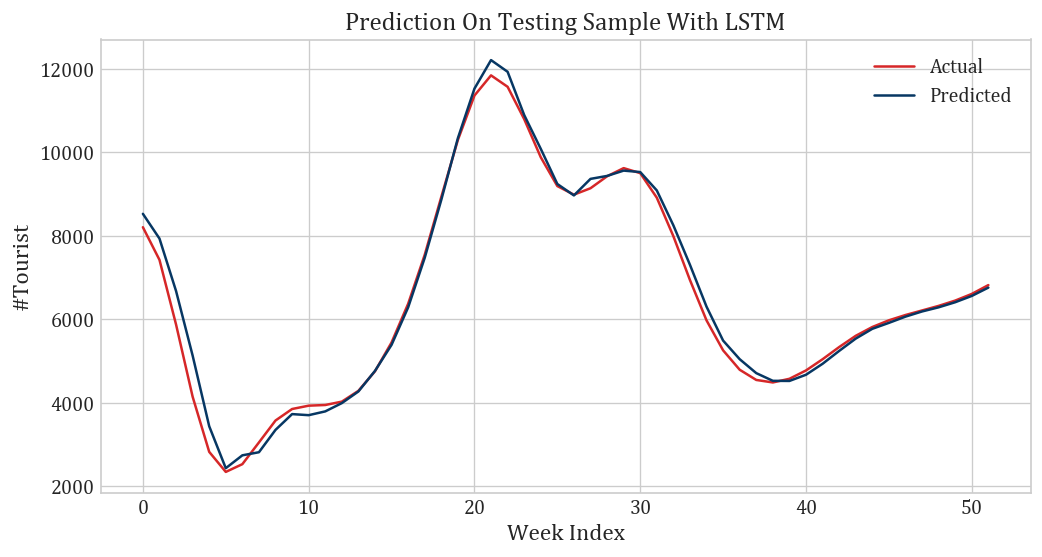

In [15]:
# walk-forward validation on the test data
predictions_test = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_LSTM(LSTM_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions_test.append(yhat)
    expected_test = raw_values[len(train) + i + 4]
    print('Week=%d, Predicted=%.0f, Expected=%.0f' % (i+1, yhat, expected_test))

# report performance
rmse_test = sqrt(mean_squared_error(raw_values[-len(test_scaled):], predictions_test))
print('---------------------------------------------------------------------------')
print('Test RMSE: %.1f' % rmse_test)
print('---------------------------------------------------------------------------')
# line plot of observed vs predicted
plt.plot(raw_values[-len(test_scaled):], label = 'Actual',color='tab:red')
plt.plot(predictions_test, label = 'Predicted',color='#073763ff')
plt.legend(loc='best')
plt.gca().set(title = "Prediction On Testing Sample With LSTM" , 
                  xlabel='Week Index', 
                  ylabel='#Tourist',)
plt.show()